In [17]:
!pip install ultralytics==8.0.186
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install albumentations==1.4


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
from PIL import Image
import cv2

In [1]:
weights_path = 'yolov8n.pt'

model = YOLO(weights_path)
model.info()


NameError: name 'YOLO' is not defined

In [4]:
from torch.nn.utils.prune import custom_from_mask
from torch.nn.utils import prune

# neck abstraction
hook_outputs = {}
def activation_hook(layer_name):
    def hook(module, input, output):
        hook_outputs[layer_name] = output
    return hook

for layer_name, layer in model.named_modules():
    if layer_name.endswith('conv'):
        layer.register_forward_hook(activation_hook(layer_name))
        
pruning_masks = {}
for module, activation in hook_outputs.items():
    is_activation_tuple = isinstance(activation, tuple)
    if not is_activation_tuple:
        mask = activation > 0
        pruning_masks[module] = mask

for name, layer in model.named_modules():
    if name in pruning_masks:
        mask = pruning_masks[name]
        custom_from_mask(layer, name='weight', mask=mask)

# head abstraction
fn = {}
idx = 0
for name in model.names:
    if model.names[name] != 'person':
        fn[idx] = model.names[name]
        idx += 1
model.model.names = fn
model.model.nc = len(fn)


# specification
image_path = "./Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg"
model(image_path)



image 1/1 /Users/karthikh/COMS-6730-Project/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg: 640x640 2 bicycles, 1 car, 5 motorcycles, 1 horse, 48.0ms
Speed: 1.8ms preprocess, 48.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bicycle', 1: 'car', 2: 'motorcycle', 3: 'airplane', 4: 'bus', 5: 'train', 6: 'truck', 7: 'boat', 8: 'traffic light', 9: 'fire hydrant', 10: 'stop sign', 11: 'parking meter', 12: 'bench', 13: 'bird', 14: 'cat', 15: 'dog', 16: 'horse', 17: 'sheep', 18: 'cow', 19: 'elephant', 20: 'bear', 21: 'zebra', 22: 'giraffe', 23: 'backpack', 24: 'umbrella', 25: 'handbag', 26: 'tie', 27: 'suitcase', 28: 'frisbee', 29: 'skis', 30: 'snowboard', 31: 'sports ball', 32: 'kite', 33: 'baseball bat', 34: 'baseball glove', 35: 'skateboard', 36: 'surfboard', 37: 'tennis racket', 38: 'bottle', 39: 'wine glass', 40: 'cup', 41: 'fork', 42: 'knife', 43: 'spoon', 44: 'bowl', 45: 'banana', 46: 'apple', 47: 'sandwich', 48: 'orange', 49: 'broccoli', 50: 'carrot', 51: 'hot dog', 52: 'pizza', 53: 'donut', 54: 'cake', 55: 'chair', 56: 'couch', 57: 'potted plant', 58: 'be

In [21]:
def get_activation_layers(module, layer_list=None):
    if layer_list is None:
        layer_list = []

    for name, child in module.named_children():
        if isinstance(child, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.SiLU, torch.nn.Softmax, torch.nn.Sigmoid)):
            module._modules[name] = torch.nn.ReLU(inplace=True)
        else:
            get_activation_layers(child, layer_list)
    
    return layer_list

def change_activation_layers(module, layer_list=None):
    if layer_list is None:
        layer_list = []

    for name, child in module.named_children():
        if isinstance(child, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.SiLU, torch.nn.Softmax, torch.nn.Sigmoid)):
            module._modules[name] = torch.nn.ReLU(inplace=True)
        else:
            get_activation_layers(child, layer_list)

# Get all activation layers
change_activation_layers(model.model)

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread
def print_results(model, results, image_path):
    for result in results:
        # Get bounding boxes in [xmin, ymin, xmax, ymax] format
        boxes = result.boxes.xyxy.cpu().numpy()  

        # Get class labels
        labels = [model.names[int(cls)] for cls in result.boxes.cls]
        
        image = imread(image_path)

        # Plot the image
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image)
        ax.axis("off")
        
        # Get confidence scores
        confidences = result.boxes.conf.cpu().numpy()

        # Example: print results for each detected object
        for bbox, label, confidence in zip(boxes, labels, confidences):
            print(f"Box: {bbox}, Label: {label}, Confidence: {confidence}")
            rect = Rectangle(
                (bbox[0], bbox[1]),  # (x_min, y_min)
                bbox[2] - bbox[0],  # width
                bbox[3] - bbox[1],  # height
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax.add_patch(rect)

            # Add label and confidence score
            label_text = f"{label} ({confidence:.2f})" if confidence else label
            ax.text(
                bbox[0],
                bbox[1] - 10,  # Position slightly above the box
                label_text,
                color="white",
                fontsize=12,
                bbox=dict(facecolor="red", edgecolor="none", alpha=0.5),
            )

In [23]:

# @author: Karthik Hanumanthaiah
# @email: karthikh@iastate.edu

# neural network file path
onnx_file_path = './dnnv-benchmarks/benchmarks/ACAS_Xu/onnx/N_1_1.onnx'
spec_file_path = "./vnncomp2022_benchmarks/benchmarks/acasxu/vnnlib/prop_2.vnnlib.gz"

import logging
from ultralytics import YOLO

logging.getLogger().setLevel(logging.FATAL)

num_process = 2
image_path = "./Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg"
def mark_activated_weights_zero(model):
    # Forward pass to get the activated neurons
    hook_outputs = {}
    def activation_hook(layer_name):
        def hook(module, input, output):
            hook_outputs[layer_name] = output
        return hook

    print("activation hook for conv layer")
    for layer_name, layer in model.named_modules():
        if layer_name.endswith('conv'):
            layer.register_forward_hook(activation_hook(layer_name))
            
    print("prune active weight -- create adversarial mask")
    pruning_masks = {}
    for module, activation in hook_outputs.items():
        is_activation_tuple = isinstance(activation, tuple)
        if not is_activation_tuple:
            mask = activation > 0
            pruning_masks[module] = mask

    print("merge adversarial mask")
    for name, layer in model.named_modules():
        if name in pruning_masks:
            mask = pruning_masks[name]
            custom_from_mask(layer, name='weight', mask=mask)

    return model
    
def create_sub_model(model):
    fn = {}
    idx = 0
    for name in model.names:
        if model.names[name] != 'person':
            fn[idx] = model.names[name]
            idx += 1
    model.model.names = fn
    model.model.nc = len(fn)
    return model

def run_specification(model):
    print("")
    model(image_path)

def f(x):
    return x*x

# main function to run abstraction, function executes based on the specification provided
def run_abstraction(counter_examples):
    weights_path = 'YoloV8/yolov8n.pt'

    model = YOLO(weights_path)
    sub_model = mark_activated_weights_zero(model)
    sub_model = create_sub_model(sub_model)
    run_specification(sub_model)
if __name__ == "__main__":
    counter_examples = [image_path]
    run_abstraction(counter_examples)


image 1/1 /Users/karthikh/COMS-6730-Project/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg: 640x640 2 bicycles, 1 car, 5 motorcycles, 1 horse, 61.1ms
Speed: 1.6ms preprocess, 61.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


activation hook for conv layer
prune active weight -- create adversarial mask
merge adversarial mask




image 1/1 /Users/karthikh/COMS-6730-Project/Person-Detection-YOLOV8N-Dectection/test/images/509_png.rf.9f35a75b1aa686f6f22202dce13f2b21.jpg: 640x640 (no detections), 51.6ms
Speed: 1.9ms preprocess, 51.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


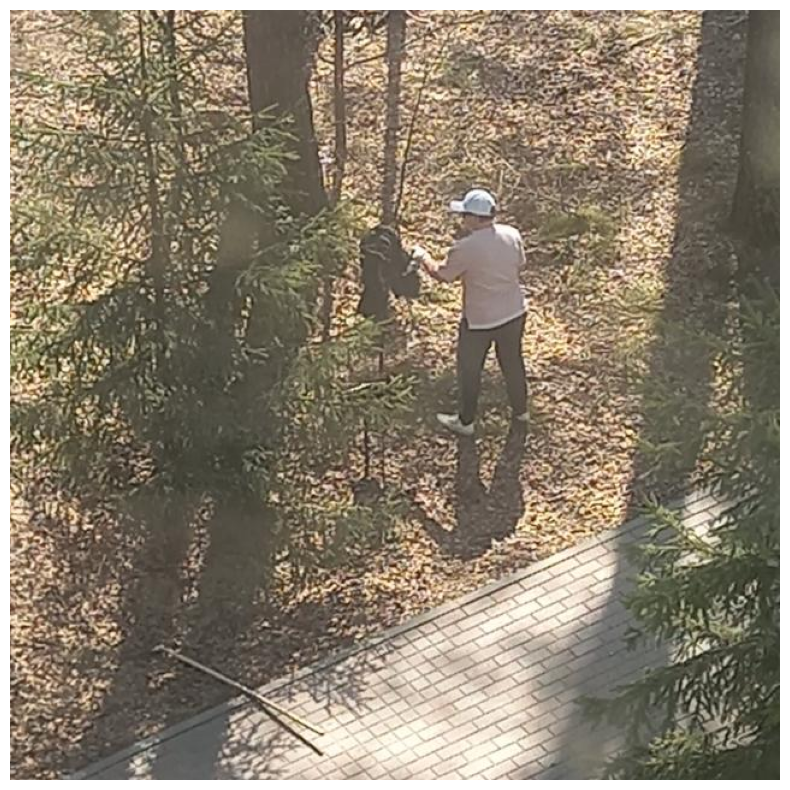

In [30]:
path = "./Person-Detection-YOLOV8N-Dectection/test/images/509_png.rf.9f35a75b1aa686f6f22202dce13f2b21.jpg"
print_results(model, model(path), path)


image 1/1 /Users/karthikh/COMS-6730-Project/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg: 640x640 2 bicycles, 1 car, 5 motorcycles, 1 horse, 59.0ms
Speed: 2.8ms preprocess, 59.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Box: [     46.073       224.2      144.44      564.74], Label: bicycle, Confidence: 0.749139666557312
Box: [     2.0759      95.694      255.35      239.59], Label: motorcycle, Confidence: 0.6984248161315918
Box: [     523.18      170.63      639.93      300.12], Label: motorcycle, Confidence: 0.5044921636581421
Box: [   0.020767      111.53      67.104      294.49], Label: horse, Confidence: 0.5022909045219421
Box: [     322.44      128.64      436.67      271.58], Label: motorcycle, Confidence: 0.3803980052471161
Box: [          0      221.83      84.205      306.07], Label: car, Confidence: 0.37121933698654175
Box: [     321.22      126.85       635.6      281.54], Label: motorcycle, Confidence: 0.3187709450721741
Box: [          0      112.15      67.272      301.29], Label: bicycle, Confidence: 0.2886233627796173
Box: [     424.31      160.14         640      298.55], Label: motorcycle, Confidence: 0.25303375720977783


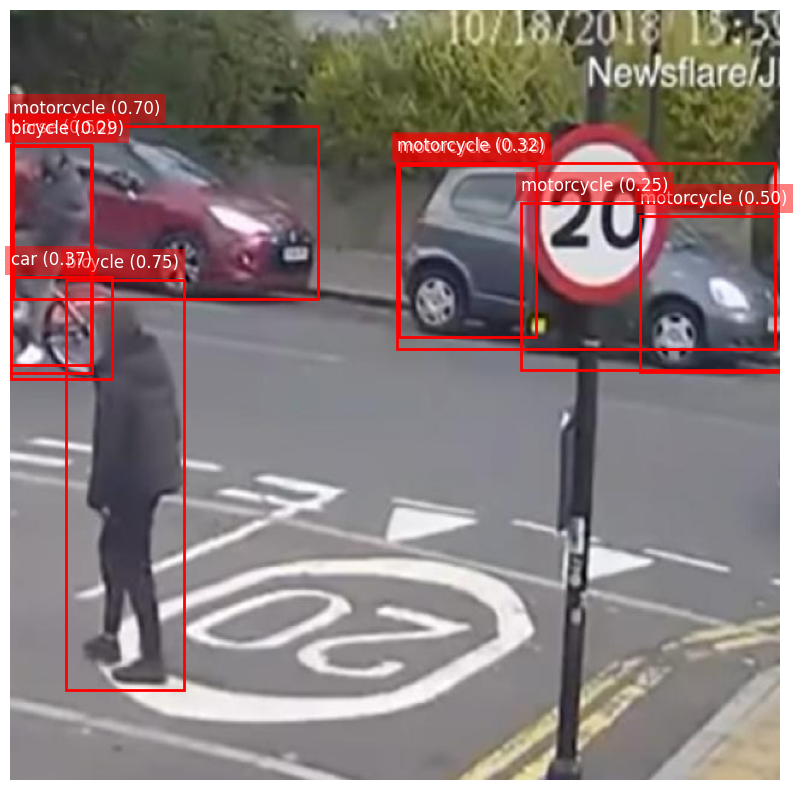

In [6]:
path = "./Person-Detection-YOLOV8N-Dectection/test/images/51_png.rf.127d6881ff6b79a0eccaa4998ac8f34b.jpg"
print_results(model, model(image_path), image_path)


image 1/1 /Users/karthikh/COMS-6730-Project/Person-Detection-YOLOV8N-Dectection/test/images/501_png.rf.2832722e1c6af543bc4d608abee40079.jpg: 640x640 (no detections), 58.6ms
Speed: 1.5ms preprocess, 58.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


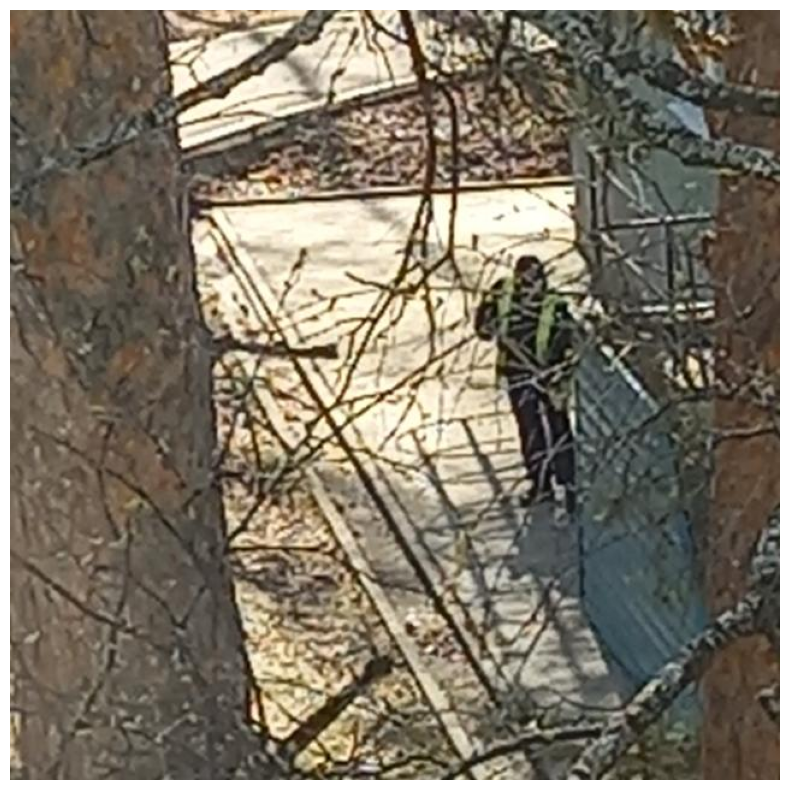

In [66]:
path = "./Person-Detection-YOLOV8N-Dectection/test/images/501_png.rf.2832722e1c6af543bc4d608abee40079.jpg"
print_results(model, model(path), path)